<a href="https://colab.research.google.com/github/kota-mizu/atmaCup-20/blob/main/notebooks/0.6165_add_pca_features_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install ydata-profiling

## ライブラリのインポート

In [2]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
from scipy import sparse as sp
import numpy as np
import pandas as pd
import polars as pl
from glob import glob
from pathlib import Path
import joblib
import pickle
import itertools
from tqdm.auto import tqdm
from datetime import datetime


import torch
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF
import lightgbm as lgb
import xgboost as xgb
# from catboost import Pool, CatBoostRegressor, CatBoostClassifier
import time

# import implicit
import scipy.stats as stats
from scipy.sparse import coo_matrix
from pprint import pprint

from abc import ABC, abstractmethod

## Config

In [3]:
# ====================================================
# Configurations
# ====================================================
class CFG:
    #実験設定
    # USE_GPU = torch.cuda.is_available()
    SEED = 42
    N_SPLIT = 4
    metric = 'auc'
    metric_maximize_flag = True
    VER = 1.3 #PCAのみを特徴量とする

    # COMPETITION = 'atmacup20'
    MAIN_PATH = '/content/drive/MyDrive/atmaCup#20' ### パスを適宜変更
    # DATA_PATH = Path(f'{MAIN_PATH}/data')
    # OUTPUT_PATH = Path(f'{MAIN_PATH}/output')
    MODEL_PATH = Path(f'{MAIN_PATH}/model/')
    SUBMISSION_PATH = Path(f'{MAIN_PATH}/submission/')
    PREPROCESSED_DATA_PATH = Path(f'{MAIN_PATH}/preprocessed_data')
    OOF_DATA_PATH = Path(f'{MAIN_PATH}/oof')
    MODEL_DATA_PATH = Path(f'{MAIN_PATH}/models')
    # バージョンごとの実験用パスを自動で作成
    EXP_MODEL_PATH = MODEL_PATH / f"exp{VER}"
    # EXP_SUBMISSION_PATH = SUBMISSION_PATH / f"exp{VER}"


    num_boost_round = 2500
    early_stopping_round = 50
    verbose = 100

    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 10000,
        'learning_rate': 0.05,
        'random_state': SEED,
        'device': 'cpu',
        "max_depth": 15,
        "num_leaves": 6,
        "colsample_bytree": 0.9,
        "colsample_bynode": 0.6,
        "reg_alpha": 3.5,
        "reg_lambda": 1.5,
        "min_child_samples": 50,
        "subsample": 0.8,
        "subsample_freq": 1,
    }
    xgb_params = {
        'tree_method': "hist",
        'objective': 'binary:logistic',
        'eval_metric': 'auc', # 'logloss',
        'n_estimators':10000,
        'early_stopping_rounds': 50,
        'learning_rate': 0.05,
        'max_depth': 6,
        'random_state': SEED,
        'gamma':0.1,
        'subsample':0.8,
        'colsample_bytree':0.3,
        'min_child_weight':3,
        'enable_categorical': True,
    }

    cat_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC', #
        'learning_rate': 0.05,
        'iterations': num_boost_round,
        'depth': 3,
        'random_seed': SEED,
    }

In [4]:
# random seedを固定
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

fix_seed(CFG.SEED)

## データの読み込み

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_DIR = '/content/drive/MyDrive/atmaCup#20/'

In [7]:
#@title データロード

class DataLoader(ABC):
    """
    データローダーの抽象クラス
    """

    def __init__(self):
        """
        初期化メソッド
        """
        pass

    @abstractmethod
    def get(self) -> pl.DataFrame:
        """
        データを取得する抽象メソッド
        サブクラスで実装する必要があります
        """
        pass

In [8]:
class TrainLoader(DataLoader):
    """train.csvファイルを読み込むためのDataLoader"""

    def __init__(self, file_path: str = "train.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
        }

        # カラム名を変更
        self.df = self.df.rename(column_mapping)

        # response_mapping = {
        #     "コーポレート管理部門/技術・データ・BPR": "corporate_ops",
        #     "事業企画・開発・研究": "business_dev",
        #     "マーケティング": "marketing",
        #     "営業": "sales",
        #     "コンテンツ・サービス・デザイン": "content_design",
        #     "プロダクトマネジメント": "product_mgmt",
        # }

        # self.df = self.df.with_columns(
        #     pl.col("category").replace_strict(response_mapping)
        # )

    def get(self):
        return self.df

In [9]:
class TestLoader(DataLoader):
    """test.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "test.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
        }

        # カラム名を変更
        self.df = self.df.rename(column_mapping)

        # response_mapping = {
        #     "コーポレート管理部門/技術・データ・BPR": "corporate_ops",
        #     "事業企画・開発・研究": "business_dev",
        #     "マーケティング": "marketing",
        #     "営業": "sales",
        #     "コンテンツ・サービス・デザイン": "content_design",
        #     "プロダクトマネジメント": "product_mgmt",
        # }

        # self.df = self.df.with_columns(
        #     pl.col("category").replace_strict(response_mapping)
        # )

    def get(self):
        return self.df

In [10]:
class CareerLoader(DataLoader):
    """career.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "career.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
            "自分の能力を発揮できる仕事上の得意分野が見つかっている\n": "found_strengths",
            "自分はどんな仕事をやりたいのか明らかである      \n": "clear_job_interest",
            "自分は何を望んで今の仕事をしているのかわかっている\n": "know_job_purpose",
            "自分なりの職業的な生き方に関する目標・目的がはっきりしている\n": "clear_career_goals",
            "自分のこれからのキャリアには、あまり関心がない\n": "low_career_interest",
            "これからのキャリアを、より充実したものにしたいと強く思う\n": "strong_career_desire",
            "キャリア設計（職業生活の設計）は、自分にとって重要な課題である\n": "career_design_important",
            "これからのキャリアをどう歩むべきか、あまり考えていない\n": "not_thinking_future_career",
            "納得いくキャリアを歩めるかどうかは、自分の責任だと思う\n": "career_satisfaction_my_responsibility",
            "キャリア形成は、自分自身の責任である\n": "career_dev_my_responsibility",
            "納得いくキャリアを歩めない原因の大半は周囲の環境にある\n": "blame_env_for_unsat_career",
            "キャリアは周りの環境によって決められていくものだと思う\n": "career_shaped_by_env",
            "新しい環境や状況にも、わりあい早くなじんで対応している": "adapt_new_env_quickly",
            "職場環境の変化に対して自分なりに考えて対応している": "respond_to_work_env_changes",
            "新しい職場に移ってもすぐに自分らしさを発揮している": "show_self_in_new_workplace",
            "職場の制度や仕事が変わってもすぐ対応している": "adapt_to_work_changes",
            "自分の職種・業界分野における最新動向を常に情報収集している": "track_industry_trends",
            "仕事のために新しいことをいろいろ勉強している": "study_new_for_work",
            "社会・経済の動きや成り行きに関する情報を、積極的に収集している": "follow_social_econ_trends",
            "新しい知識・技術を積極的に学ぶように努めている": "learn_new_tech",
            "新しい人間関係が構築できるように、社内外の活動に積極的に参加している": "build_relations_actively",
            "仕事と直接関係ない人とも積極的に交流するようにしている": "interact_beyond_work",
            "新しいネットワークづくりに常に取り組んでいる": "build_new_networks",
            "自分の満足感を高めるように、仕事のやり方を工夫している": "improve_work_for_satisfaction",
            "常に自発的に仕事を行っている": "work_proactively",
            "自分の価値観やポリシーを持って仕事に取り組んでいる": "work_with_values",
            "仕事の進め方や企画を立てる上で、今までの延長上のやり方ではなく、自分なりの発想を持って取り組んでいる": "creative_work_planning",
            "少人数チームで協力してタスクを完遂できる": "small_team_collab",
            "メンバー全員のアイデアを取り入れて成果物を作れる": "integrate_team_ideas",
            "同僚や上司に向けて口頭でプレゼンテーションができる": "oral_presentation",
            "スライドや動画などのデジタル資料を用いて情報を共有できる": "share_info_digitally",
            "異なる視点を比較して最適な解決策を選べる": "compare_views_find_solution",
            "正解が一つでない問題に対して解決策を導き出せる": "solve_ambiguous_problems",
            "複数のアイデアを試行し改善を重ねられる": "iterate_ideas_improve",
            "困難な業務課題に対して独自の解決策を考案できる": "create_unique_solutions",
            "自分の進捗をモニタリングし計画を柔軟に調整できる": "monitor_and_adjust_plan",
            "フィードバックを受けて自ら仕事を改善できる": "use_feedback_to_improve",
            "業務データを可視化し\xa0BI\xa0ダッシュボードで意思決定に活用できる": "use_bi_for_decision",
            "RPA／ノーコードツールで反復的な業務フローを自動化できる": "automate_with_rpa",
            "生成\xa0AI\xa0や機械学習モデルを業務改善に活用できる": "use_ai_ml_for_improvement",
            "クラウド環境のアクセス権限を監査し情報保護を徹底できる": "audit_cloud_security",
            "デジタルマーケティング施策（SNS\xa0広告等）をデータで最適化できる": "optimize_digital_marketing",
            "顧客・市場データを用いて新商品・サービス企画を立案できる": "plan_products_with_data",
            "クラウド／DevOps\xa0環境を構築し\xa0IaC\xa0で継続的デプロイを管理できる": "manage_devops_with_iac",
            "デジタルツインや\xa0IoT\xa0データを用いたサプライチェーン最適化を提案・実装できる": "optimize_supply_with_iot",
        }

        # カラム名を変更
        self.df = self.df.rename(column_mapping)

        response_mapping = {
            "1 全くそう思わない／全く当てはまらない": 1,
            "2 あまりそう思わない／あまり当てはまらない": 2,
            "3 どちらとも言えない": 3,
            "4 そう思う／当てはまる": 4,
            "5 強くそう思う／とても当てはまる ": 5,
            "5 強くそう思う／とても当てはまる": 5,
        }

        target_cols = [col for col in self.df.columns if col != "employee_id"]

        # 各列にマッピングを適用して更新
        for col in target_cols:
            self.df = self.df.with_columns(
                pl.col(col).replace_strict(response_mapping)
            )

    def get(self):
        return self.df

In [11]:
class DXLoader(DataLoader):
    """dx.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "dx.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
            "研修実施日": "training_date",
            "研修カテゴリ": "training_category",
            "研修名": "training_name",
        }

        self.df = self.df.rename(column_mapping)

        self.df = self.df.with_columns(
            pl.col("training_date").str.strptime(pl.Date, "%F %T", strict=False),
        )

        enc = LabelEncoder()
        self.df = self.df.with_columns(
            pl.col("training_category").map_batches(enc.fit_transform)
        )

        enc = LabelEncoder()
        self.df = self.df.with_columns(
            pl.col("training_name").map_batches(enc.fit_transform)
        )

    def get(self):
        return self.df


In [12]:
class HRLoader(DataLoader):
    """hr.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "dx.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
            "カテゴリ": "hr_training_category",
            "研修名": "hr_training_name",
            "実施日": "hr_training_date",
        }

        self.df = self.df.rename(column_mapping)

        self.df = self.df.with_columns(
            pl.col("hr_training_date").str.split(",")  # カンマで分割してリストに
        ).explode("hr_training_date")  # リストを縦に展開

        # TODO: 日付のフォーマットが複数あるので、coalesceでフォーマットを変換
        # self.df = self.df.with_columns(
        #     pl.col("hr_training_date").map_elements(extract_dates_polars, return_dtype=pl.List(pl.String)).alias("hr_training_date")
        # ).explode("hr_training_date")

        self.df = self.df.with_columns([
            pl.coalesce([
                pl.col("hr_training_date").str.strptime(pl.Date, "%Y/%m/%d", strict=False),
                pl.col("hr_training_date").str.strptime(pl.Date, "%Y-%m-%d %H:%M:%S", strict=False)
            ])
        ])

        enc = LabelEncoder()
        self.df = self.df.with_columns(
            pl.col("hr_training_category").map_batches(enc.fit_transform)
        )

        enc = LabelEncoder()
        self.df = self.df.with_columns(
            pl.col("hr_training_name").map_batches(enc.fit_transform)
        )


    def get(self):
        return self.df

In [13]:
class OvertimeWorkLoader(DataLoader):
    """overtime_work_by_month.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "overtime_work_by_month.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
        }

        self.df = self.df.rename(column_mapping)

    def get(self):
        return self.df

In [14]:
class PositionHistoryLoader(DataLoader):
    """position_history.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "position_history.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
            "year": "year",
            "勤務区分": "work_category",
            "役職": "position"
        }

        self.df = self.df.rename(column_mapping)

        self.df = self.df.with_columns(
            pl.col("work_category").map_batches(LabelEncoder().fit_transform)
        )

        self.df = self.df.with_columns(
            pl.col("position").map_batches(LabelEncoder().fit_transform)
        )

    def get(self):
        return self.df

In [15]:
class UdemyActivityLoader(DataLoader):
    """udemy_activity.csvファイル用のDataLoader"""

    def __init__(self, file_path: str = "udemy_activity.csv"):
        super().__init__()
        self.file_path = file_path
        self.df = pl.read_csv(self.file_path)

        column_mapping = {
            "社員番号": "employee_id",
            "コースID": "course_id",
            "コースタイトル": "course_title",
            "レクチャーもしくはクイズ": "lecture_or_quiz",
            "レクチャー/クイズID": "lecture_or_quiz_id",
            "レクチャー/クイズの題名": "lecture_or_quiz_title",
            "開始日": "start_date",
            "終了日": "end_date",
            "推定完了率%": "estimated_completion_rate_percent",
            "最終結果（クイズの場合）": "final_result_if_quiz",
            "マーク済み修了": "marked_as_completed",
            "コースカテゴリー": "course_category",
        }

        self.df = self.df.rename(column_mapping)

        # カテゴリ変数
        self.df = self.df.with_columns(
            pl.col("lecture_or_quiz_id").cast(pl.Utf8).cast(pl.Utf8)
        )

        self.df = self.df.with_columns(
            [
                pl.coalesce(
                    [
                        pl.col("start_date").str.strptime(
                            pl.Datetime, "%Y/%m/%d %H:%M", strict=False
                        )
                    ]
                )
            ]
        ).with_columns(
            [
                pl.coalesce(
                    [
                        pl.col("end_date").str.strptime(
                            pl.Datetime, "%Y/%m/%d %H:%M", strict=False
                        )
                    ]
                )
            ]
        )

        self.df = self.df.with_columns(
            pl.col("course_title").map_batches(LabelEncoder().fit_transform)
        )

        self.df = self.df.with_columns(
            pl.col("lecture_or_quiz_title").map_batches(LabelEncoder().fit_transform)
        )

        self.df = self.df.with_columns(
            pl.col("course_category").map_batches(LabelEncoder().fit_transform)
        )

    def get(self):
        return self.df

In [16]:
# Load
train = TrainLoader(DATA_DIR + "train.csv").get()
test = TestLoader(DATA_DIR + "test.csv").get()
career = CareerLoader(DATA_DIR + "career.csv").get()
dx = DXLoader(DATA_DIR + "dx.csv").get()
hr = HRLoader(DATA_DIR + "hr.csv").get()
overtime_work = OvertimeWorkLoader(DATA_DIR + "overtime_work_by_month.csv").get()
position_history = PositionHistoryLoader(DATA_DIR + "position_history.csv").get()
udemy_activity = UdemyActivityLoader(DATA_DIR + "udemy_activity.csv").get()

In [17]:
udemy_activity

employee_id,course_id,course_title,lecture_or_quiz,lecture_or_quiz_id,lecture_or_quiz_title,start_date,end_date,estimated_completion_rate_percent,final_result_if_quiz,marked_as_completed,course_category
str,i64,i64,str,str,i64,datetime[μs],datetime[μs],f64,f64,bool,i64
"""-1sqs0GXzpPJuAVKHUUFgg==""",4615016,3012,"""Quiz""","""5528090""",62746,2022-04-11 10:10:00,2022-04-11 10:10:00,100.0,0.0,true,270
"""-1sqs0GXzpPJuAVKHUUFgg==""",4615016,3012,"""Quiz""","""5528090""",62746,2022-04-11 10:11:00,2022-04-11 10:11:00,100.0,100.0,true,270
"""-1sqs0GXzpPJuAVKHUUFgg==""",4615016,3012,"""Quiz""","""5528100""",62746,2022-04-11 10:26:00,2022-04-11 10:26:00,100.0,0.0,true,270
"""-1sqs0GXzpPJuAVKHUUFgg==""",4615016,3012,"""Quiz""","""5528100""",62746,2022-04-11 10:27:00,2022-04-11 10:27:00,100.0,100.0,true,270
"""-1sqs0GXzpPJuAVKHUUFgg==""",4615016,3012,"""Quiz""","""5528102""",62746,2022-04-11 10:21:00,2022-04-11 10:21:00,100.0,100.0,true,270
…,…,…,…,…,…,…,…,…,…,…,…
"""zxY0Eflwm1tYj1Wt6vo_1g==""",5264112,3012,"""Video_lecture""","""37311144""",62746,2023-06-14 09:56:00,2023-06-14 09:56:00,100.0,null,true,270
"""zxY0Eflwm1tYj1Wt6vo_1g==""",5264112,3012,"""Video_lecture""","""37311150""",62746,2023-06-14 09:57:00,2023-06-14 09:57:00,100.0,null,true,270
"""zxY0Eflwm1tYj1Wt6vo_1g==""",6098315,3012,"""Video_lecture""","""45012691""",62746,2024-09-27 15:39:00,2024-09-27 16:17:00,100.0,null,true,270


## 特徴量の作成

In [18]:
# input session
def attach_fold(df) -> pl.DataFrame:

  # どのfoldも同じくらいpositive例が出現するようにstratifiedにする
  sgkf = StratifiedGroupKFold(n_splits=CFG.N_SPLIT)

  folds = [
      df[test_index].select("employee_id").with_columns(
          pl.lit(i).alias("fold")
      ) for i, (train_index, test_index) in enumerate(sgkf.split(df, df["target"], df["employee_id"]))
  ]

  return df.join(pl.concat(folds), on="employee_id", how="left")

train = attach_fold(train)

### dx

In [19]:
dx_training_category = dx[["employee_id", "training_category", "training_date"]].pivot("training_category", index="employee_id", aggregate_function="len")
prefix = "dx_training_category_"
dx_training_category = dx_training_category.rename({col: prefix + col for col in dx_training_category.columns if col != "employee_id"})

dx_training_name = dx[["employee_id", "training_name", "training_date"]].pivot("training_name", index="employee_id", aggregate_function="len")
prefix = "dx_training_name_"
dx_training_name = dx_training_name.rename({col: prefix + col for col in dx_training_name.columns if col != "employee_id"})

### hr

In [20]:
hr_training_category = hr[["employee_id", "hr_training_category", "hr_training_date"]].pivot("hr_training_category", index="employee_id", aggregate_function="len")
prefix = "hr_training_category_"
hr_training_category = hr_training_category.rename({col: prefix + col for col in hr_training_category.columns if col != "employee_id"})

hr_training_name = hr[["employee_id", "hr_training_name", "hr_training_date"]].pivot("hr_training_name", index="employee_id", aggregate_function="len")
prefix = "hr_training_name_"
hr_training_name = hr_training_name.rename({col: prefix + col for col in hr_training_name.columns if col != "employee_id"})

### udemy_activity

In [21]:
udemy_activity_numerical = udemy_activity.group_by("employee_id").agg([
  # estimated_completion_rate_percent
  pl.col("estimated_completion_rate_percent").mean().alias("estimated_completion_rate_percent_mean"),
  pl.col("estimated_completion_rate_percent").min().alias("estimated_completion_rate_percent_min"),
  pl.col("estimated_completion_rate_percent").max().alias("estimated_completion_rate_percent_max"),
  pl.col("estimated_completion_rate_percent").std().alias("estimated_completion_rate_percent_std"),
  pl.col("estimated_completion_rate_percent").count().alias("estimated_completion_rate_percent_count"),

  # final_result_if_quiz
  pl.col("final_result_if_quiz").mean().alias("final_result_if_quiz_mean"),
  pl.col("final_result_if_quiz").min().alias("final_result_if_quiz_min"),
  pl.col("final_result_if_quiz").max().alias("final_result_if_quiz_max"),
  pl.col("final_result_if_quiz").std().alias("final_result_if_quiz_std"),
  pl.col("final_result_if_quiz").count().alias("final_result_if_quiz_count"),

  # marked_as_completed
  pl.col("marked_as_completed").mean().alias("marked_as_completed_mean"),
  pl.col("marked_as_completed").min().alias("marked_as_completed_min"),
  pl.col("marked_as_completed").max().alias("marked_as_completed_max"),
  pl.col("marked_as_completed").std().alias("marked_as_completed_std"),
  pl.col("marked_as_completed").count().alias("marked_as_completed_count"),
])


udemy_activity_course_category = udemy_activity[["employee_id", "course_category", "start_date"]].pivot("course_category", index="employee_id", aggregate_function="len")
prefix = "udemy_activity_course_category_"
udemy_activity_course_category = udemy_activity_course_category.rename({col: prefix + col for col in udemy_activity_course_category.columns if col != "employee_id"})


udemy_activity_lecture_or_quiz = udemy_activity[["employee_id", "lecture_or_quiz", "start_date"]].pivot("lecture_or_quiz", index="employee_id", aggregate_function="len")
prefix = "udemy_activity_lecture_or_quiz_"
udemy_activity_lecture_or_quiz = udemy_activity_lecture_or_quiz.rename({col: prefix + col for col in udemy_activity_lecture_or_quiz.columns if col != "employee_id"})


# udemy_activity_course_id = udemy_activity[["employee_id", "course_id", "start_date"]].pivot("course_id", index="employee_id", aggregate_function="len")

### career

### position_history

In [22]:
position_history_work_category = position_history[["employee_id", "work_category", "year"]].pivot("work_category", index="employee_id", aggregate_function="len")
prefix = "position_history_work_category_"
position_history_work_category = position_history_work_category.rename({col: prefix + col for col in position_history_work_category.columns if col != "employee_id"})

position_history_position = position_history[["employee_id", "position", "year"]].pivot("position", index="employee_id", aggregate_function="len")
prefix = "position_history_position_"
position_history_position = position_history_position.rename({col: prefix + col for col in position_history_position.columns if col != "employee_id"})

### overtime_work_by_month

In [23]:
overtime_work = overtime_work.group_by("employee_id").agg([
  pl.col("hours").mean().alias("hours_mean"),
  pl.col("hours").min().alias("hours_min"),
  pl.col("hours").max().alias("hours_max"),
  pl.col("hours").std().alias("hours_std"),
  pl.col("hours").count().alias("hours_count"),
])

### データのマージ

In [25]:
train_df = train.join(
    career, on="employee_id", how="left"
).join(
    dx_training_category, on="employee_id", how="left"
).join(
    dx_training_name, on="employee_id", how="left"
).join(
    hr_training_category, on="employee_id", how="left"
).join(
    hr_training_name, on="employee_id", how="left"
).join(
    overtime_work, on="employee_id", how="left"
).join(
    position_history_work_category, on="employee_id", how="left"
).join(
    position_history_position, on="employee_id", how="left"
).join(
    udemy_activity_numerical, on="employee_id", how="left"
).join(
    udemy_activity_course_category, on="employee_id", how="left"
).join(
    udemy_activity_lecture_or_quiz, on="employee_id", how="left"
# ).join(
#     udemy_activity_course_id, on="employee_id", how="left"
)

assert len(train) == len(train_df)

In [27]:
test_df = test.join(
    career, on="employee_id", how="left"
).join(
    dx_training_category, on="employee_id", how="left"
).join(
    dx_training_name, on="employee_id", how="left"
).join(
    hr_training_category, on="employee_id", how="left"
).join(
    hr_training_name, on="employee_id", how="left"
).join(
    overtime_work, on="employee_id", how="left"
).join(
    position_history_work_category, on="employee_id", how="left"
).join(
    position_history_position, on="employee_id", how="left"
).join(
    udemy_activity_numerical, on="employee_id", how="left"
).join(
    udemy_activity_course_category, on="employee_id", how="left"
).join(
    udemy_activity_lecture_or_quiz, on="employee_id", how="left"
# ).join(
#     udemy_activity_course_id, on="employee_id", how="left"
)

assert len(test) == len(test_df)

PCA

In [28]:
import polars as pl
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# この関数は、trainとtestのpolarsデータフレームと特徴量のリストを受け取ります
def create_pca_features(train_df: pl.DataFrame, test_df: pl.DataFrame, feature_cols: list, n_components: int, prefix: str) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    PCAを学習し、主成分と再構築誤差に関する特徴量を生成する関数。
    データリークを防ぐため、fitはtrainデータのみで行い、transformはtrain/test両方に適用する。

    Args:
        train_df (pl.DataFrame): 学習用データフレーム
        test_df (pl.DataFrame): テスト用データフレーム
        feature_cols (list): PCAを適用する列名のリスト
        n_components (int): 作成する主成分の数
        prefix (str): 生成される列名につける接頭辞 (例: 'all_features')

    Returns:
        tuple: (train_df_out, test_df_out) PCA特徴量が追加されたデータフレーム
    """

    print(f"--- Processing PCA for '{prefix}' features ---")

    # 1. 欠損値と無限大を0で埋める
    train_features_filled = train_df.select(feature_cols).fill_null(0)
    test_features_filled = test_df.select(feature_cols).fill_null(0)

    float_cols = [c for c in feature_cols if train_features_filled[c].dtype in [pl.Float32, pl.Float64]]

    train_features = train_features_filled.with_columns(
        pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
        for c in float_cols
    )
    test_features = test_features_filled.with_columns(
        pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
        for c in float_cols
    )

    # 2. スケーラーとPCAのインスタンスを作成
    scaler = StandardScaler()
    pca = PCA(n_components=n_components, random_state=42)

    # 3. trainデータのみでスケーラーとPCAを学習(fit)し、変換(transform)する
    train_scaled = scaler.fit_transform(train_features.to_numpy())
    train_pca = pca.fit_transform(train_scaled)

    # --- ↓↓↓ ここに寄与率を表示するコードを追加しました ↓↓↓ ---
    print(f"寄与率 (Explained Variance Ratio): {pca.explained_variance_ratio_}")
    print(f"累積寄与率 (Cumulative Explained Variance): {np.cumsum(pca.explained_variance_ratio_)}")
    # ---------------------------------------------------------

    # 4. 学習済みのモデルを使って、testデータを変換(transform)する
    test_scaled = scaler.transform(test_features.to_numpy())
    test_pca = pca.transform(test_scaled)

    # 5. 主成分をpolars DataFrameに変換
    pc_cols = [f'pca_{prefix}_{i+1}' for i in range(n_components)]
    train_pca_df = pl.DataFrame(train_pca, schema=pc_cols)
    test_pca_df = pl.DataFrame(test_pca, schema=pc_cols)

    # 6. PCAで変換したデータを元の次元に逆変換（再構築）
    train_reconstructed = pca.inverse_transform(train_pca)
    test_reconstructed = pca.inverse_transform(test_pca)

    # 7. 再構築誤差に関する特徴量を計算
    train_cossim = np.array([
        np.dot(orig, recon) / (np.linalg.norm(orig) * np.linalg.norm(recon)) if (np.linalg.norm(orig) * np.linalg.norm(recon)) > 0 else 0
        for orig, recon in zip(train_scaled, train_reconstructed)
    ])
    test_cossim = np.array([
        np.dot(orig, recon) / (np.linalg.norm(orig) * np.linalg.norm(recon)) if (np.linalg.norm(orig) * np.linalg.norm(recon)) > 0 else 0
        for orig, recon in zip(test_scaled, test_reconstructed)
    ])

    train_norm_ratio = np.array([
        np.linalg.norm(recon) / np.linalg.norm(orig) if np.linalg.norm(orig) > 0 else 0
        for orig, recon in zip(train_scaled, train_reconstructed)
    ])
    test_norm_ratio = np.array([
        np.linalg.norm(recon) / np.linalg.norm(orig) if np.linalg.norm(orig) > 0 else 0
        for orig, recon in zip(test_scaled, test_reconstructed)
    ])

    # 8. 元のDataFrameに新しい特徴量を結合
    train_df_out = train_df.with_columns(
        pl.lit(train_cossim).alias(f'{prefix}_pca_cossim'),
        pl.lit(train_norm_ratio).alias(f'{prefix}_pca_norm_ratio')
    )
    train_df_out = pl.concat([train_df_out, train_pca_df], how="horizontal")

    test_df_out = test_df.with_columns(
        pl.lit(test_cossim).alias(f'{prefix}_pca_cossim'),
        pl.lit(test_norm_ratio).alias(f'{prefix}_pca_norm_ratio')
    )
    test_df_out = pl.concat([test_df_out, test_pca_df], how="horizontal")

    return train_df_out, test_df_out


In [29]:
# --- 関数の実行例 ---
# 1. 全結合済みのtrain_df, test_dfから、PCAにかけたい数値特徴量のリストを作成する
#    (IDやtarget、カテゴリ変数などを除外する)
all_numerical_features = [col for col in train_df.columns if train_df[col].dtype != pl.Object and col not in ['employee_id', 'target', 'fold', 'category', 'marked_as_completed_min', 'marked_as_completed_max']]

# 2. 作成したリストを使って、一度にPCA特徴量を生成する
train_df, test_df = create_pca_features(train_df, test_df, all_numerical_features, n_components=200, prefix='all')

# print("PCA特徴量の作成が完了しました。")
print(train_df.head())


--- Processing PCA for 'all' features ---
寄与率 (Explained Variance Ratio): [0.09624064 0.04237172 0.03683767 0.03006218 0.01823036 0.01505148
 0.01438556 0.01333695 0.01209922 0.01165888 0.01142112 0.01097902
 0.01037527 0.00965797 0.00938498 0.00899436 0.00882213 0.00853642
 0.00847996 0.00810864 0.00790276 0.00757929 0.00735389 0.00726259
 0.00720025 0.00700961 0.00687256 0.00675467 0.00657184 0.00641038
 0.00627491 0.00612582 0.00608408 0.00597286 0.00585027 0.00580199
 0.00574365 0.00562519 0.00556016 0.00548472 0.00543306 0.00528433
 0.00521453 0.00517929 0.00503583 0.00495065 0.00487549 0.00480556
 0.00474012 0.00470107 0.00460059 0.00455215 0.00451369 0.00444965
 0.00439931 0.00431521 0.0042932  0.0042406  0.00423169 0.00417736
 0.00414092 0.0040978  0.00408536 0.00401057 0.00397737 0.00392137
 0.00383114 0.00380587 0.00372652 0.0036826  0.0036554  0.00357142
 0.00354955 0.00352706 0.00345576 0.00344633 0.00336224 0.00332473
 0.00331969 0.00329098 0.00326608 0.00323678 0.00322442

In [30]:
train_df = train_df.drop(all_numerical_features)

In [33]:
test_df = test_df.drop(all_numerical_features)

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

statistic,employee_id,category,found_strengths,clear_job_interest,know_job_purpose,clear_career_goals,low_career_interest,strong_career_desire,career_design_important,not_thinking_future_career,career_satisfaction_my_responsibility,career_dev_my_responsibility,blame_env_for_unsat_career,career_shaped_by_env,adapt_new_env_quickly,respond_to_work_env_changes,show_self_in_new_workplace,adapt_to_work_changes,track_industry_trends,study_new_for_work,follow_social_econ_trends,learn_new_tech,build_relations_actively,interact_beyond_work,build_new_networks,improve_work_for_satisfaction,work_proactively,work_with_values,creative_work_planning,small_team_collab,integrate_team_ideas,oral_presentation,share_info_digitally,compare_views_find_solution,solve_ambiguous_problems,iterate_ideas_improve,…,pca_all_64,pca_all_65,pca_all_66,pca_all_67,pca_all_68,pca_all_69,pca_all_70,pca_all_71,pca_all_72,pca_all_73,pca_all_74,pca_all_75,pca_all_76,pca_all_77,pca_all_78,pca_all_79,pca_all_80,pca_all_81,pca_all_82,pca_all_83,pca_all_84,pca_all_85,pca_all_86,pca_all_87,pca_all_88,pca_all_89,pca_all_90,pca_all_91,pca_all_92,pca_all_93,pca_all_94,pca_all_95,pca_all_96,pca_all_97,pca_all_98,pca_all_99,pca_all_100
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""11022""","""11022""",1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,1272.0,…,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0,11022.0
"""null_count""","""0""","""0""",9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,9750.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,3.726415,3.641509,3.79717,3.584906,1.957547,4.358491,4.216981,2.15566,4.099057,4.084906,2.382075,2.693396,3.787736,4.066038,3.575472,3.754717,3.377358,3.514151,3.330189,3.570755,2.853774,3.141509,2.820755,3.783019,3.863208,4.018868,3.872642,4.084906,3.745283,3.900943,4.014151,3.877358,3.816038,3.886792,…,-0.149625,-0.109827,-0.034845,0.037672,-0.074486,-0.106928,0.113364,0.206468,0.170094,-0.064603,-0.139086,0.109661,0.132697,-0.328699,-0.307029,-0.199498,-0.161609,0.2248,0.070692,0.081987,-0.018728,0.084869,-0.288289,0.025437,-0.016952,-0.109616,-0.098557,-0.061606,0.101188,-0.095614,0.205444,-0.130832,-0.008351,0.010975,-0.091387,-0.030751,0.019194
"""std""",null,null,0.753065,0.871133,0.853405,0.925566,0.968305,0.736017,0.758956,0.981007,0.749256,0.77268,0.813106,0.934699,0.845541,0.56271,0.889998,0.704862,0.941594,0.919132,0.944286,0.812778,1.17902,1.173578,1.088937,0.733654,0.755883,0.672927,0.678643,0.584907,0.740782,0.792132,0.67654,0.602165,0.71345,0.634504,…,4.505142,2.550931,3.583188,3.444348,4.059065,3.443272,4.044159,5.284009,5.217418,4.149585,3.190245,3.403778,2.227761,6.604829,4.458299,3.058953,3.037371,3.64328,4.380967,2.215644,2.859109,8.710501,4.629613,3.806337,2.115648,4.334916,3.652921,2.762257,2.753231,3.730394,6.785271,3.643522,4.411571,3.159534,2.875278,5.090141,3.059552
"""min""","""-1sqs0GXzpPJuAVKHUUFgg==""","""コンテンツ・サービス・デザイン""",2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.

## モデルの学習

In [34]:
# 予測結果やモデルを格納するためのリストを初期化
pred_dfs = []
true_dfs = []
# lgbm専用のモデルリストを作成
lgbm_models = []

# N_SPLITで定義された回数だけ、交差検証のループを実行
for fold in range(CFG.N_SPLIT):

  print(f"#### Fold: {fold} ####")

  # --- データの分割 ---
  _train_df = train_df.filter(
      pl.col("fold") != fold
  )
  _val_df = train_df.filter(
      pl.col("fold") == fold
  )

  # --- 特徴量とターゲットの分離 ---
  X_train = _train_df.drop(["employee_id", "target", "fold"])
  y_train = _train_df["target"]
  X_val = _val_df.drop(["employee_id", "target", "fold"])
  y_val = _val_df["target"]

  # --- データ型の変換 ---
  X_train = X_train.with_columns(
      pl.col("category").cast(pl.Categorical),
      pl.col("marked_as_completed_min").cast(pl.Float64),
      pl.col("marked_as_completed_max").cast(pl.Float64)
  )
  X_val = X_val.with_columns(
      pl.col("category").cast(pl.Categorical),
      pl.col("marked_as_completed_min").cast(pl.Float64),
      pl.col("marked_as_completed_max").cast(pl.Float64)
  )

  # --- LightGBMモデルの学習 ---
  # 1. lgbm専用の分類器インスタンスを作成
  lgbm_clf = lgb.LGBMClassifier(**CFG.lgb_params)

  # 2. 検証用データセットとコールバックを定義
  eval_set = [(X_val.to_pandas(), y_val.to_pandas())]
  callbacks = [
      lgb.early_stopping(stopping_rounds=100),
      lgb.log_evaluation(period=100) # 100回ごとにログを表示
  ]

  # 3. カテゴリカル特徴量を指定してモデルを学習
  cat_list = ["category"]
  lgbm_clf.fit(
      X_train.to_pandas(),
      y_train.to_pandas(),
      eval_set=eval_set,
      categorical_feature = cat_list,
      callbacks=callbacks
  )

  # モデルを保存するディレクトリを作成（存在しない場合のみ）
  CFG.EXP_MODEL_PATH.mkdir(parents=True, exist_ok=True)

  # 4. 学習済みモデルを保存（ファイル名に'lgb'を含める）
  best_model_path = CFG.EXP_MODEL_PATH / f"exp{CFG.VER}_lgb_fold_{fold}.model"
  lgbm_clf.booster_.save_model(best_model_path)
  # lgbm専用のリストにモデルを追加
  lgbm_models.append(lgbm_clf)

  # 検証用データで予測を実行
  pred = lgbm_clf.predict_proba(X_val.to_pandas())

  # 予測結果（応募確率）と正解ラベルをリストに格納
  pred_dfs.append(pred[:, 1])
  true_dfs.append(y_val)

#### Fold: 0 ####
[LightGBM] [Info] Number of positive: 1302, number of negative: 31710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51523
[LightGBM] [Info] Number of data points in the train set: 33012, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039440 -> initscore=-3.192731
[LightGBM] [Info] Start training from score -3.192731
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.698944
Early stopping, best iteration is:
[49]	valid_0's auc: 0.703743
#### Fold: 1 ####
[LightGBM] [Info] Number of positive: 1296, number of negative: 31716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

In [38]:
def calc_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score

In [36]:
calc_score(
    pl.concat(true_dfs),
    pl.concat([pl.Series(pred_df) for pred_df in pred_dfs])
)

np.float64(0.6693953006168879)

In [37]:
import xgboost as xgb
import pandas as pd
import polars as pl
from pathlib import Path

# (CFGクラスの定義は事前に行われていると仮定します)
# class CFG:
#     ...

# 予測結果やモデルを格納するためのリストを初期化
pred_dfs = []
true_dfs = []
xgb_models = []

# N_SPLITで定義された回数だけ、交差検証のループを実行
for fold in range(CFG.N_SPLIT):

  print(f"#### Fold: {fold} ####")

  # --- データの分割 ---
  # 現在のfold番号以外のデータを学習用（train）とする
  _train_df = train_df.filter(
      pl.col("fold") != fold
  )
  # 現在のfold番号のデータを検証用（validation）とする
  _val_df = train_df.filter(
      pl.col("fold") == fold
  )

  # --- 特徴量とターゲットの分離 ---
  X_train = _train_df.drop(["employee_id", "target", "fold"])
  y_train = _train_df["target"]
  X_val = _val_df.drop(["employee_id", "target", "fold"])
  y_val = _val_df["target"]

  # --- データ型の変換 ---
  # XGBoostがカテゴリカル特徴量を正しく認識できるように型を変換する
  X_train = X_train.with_columns(
      pl.col("category").cast(pl.Categorical),
      pl.col("marked_as_completed_min").cast(pl.Float64),
      pl.col("marked_as_completed_max").cast(pl.Float64)
  )
  X_val = X_val.with_columns(
      pl.col("category").cast(pl.Categorical),
      pl.col("marked_as_completed_min").cast(pl.Float64),
      pl.col("marked_as_completed_max").cast(pl.Float64)
  )

  # --- XGBoostモデルの学習 ---
  # 1. CFGで定義したパラメータを使って、XGBoost分類器のインスタンスを作成
  xgb_clf = xgb.XGBClassifier(**CFG.xgb_params)

  # 2. 検証用データセットを定義
  eval_set = [(X_val.to_pandas(), y_val.to_pandas())]

  # 3. モデルを学習させる
  # Note: 早期終了（Early stopping）はCFG.xgb_params内の'early_stopping_rounds'で制御される
  # Note: ログの表示頻度は'verbose'パラメータで制御される
  xgb_clf.fit(
      X_train.to_pandas(),
      y_train.to_pandas(),
      eval_set=eval_set,
      verbose=100 # 100イテレーションごとにログを表示
  )

  # モデルを保存するディレクトリを作成（存在しない場合のみ）
  CFG.EXP_MODEL_PATH.mkdir(parents=True, exist_ok=True)

  # 4. 学習済みモデルを保存
  best_model_path = CFG.EXP_MODEL_PATH / f"exp{CFG.VER}_xgb_fold_{fold}.json"
  xgb_clf.save_model(best_model_path)
  xgb_models.append(xgb_clf)

  # 検証用データで予測を実行
  pred = xgb_clf.predict_proba(X_val.to_pandas())

  # 予測結果（応募確率）と正解ラベルをリストに格納
  pred_dfs.append(pred[:, 1])
  true_dfs.append(y_val)

#### Fold: 0 ####
[0]	validation_0-auc:0.53090
[100]	validation_0-auc:0.66257
[156]	validation_0-auc:0.65924
#### Fold: 1 ####
[0]	validation_0-auc:0.52753
[51]	validation_0-auc:0.60982
#### Fold: 2 ####
[0]	validation_0-auc:0.55026
[77]	validation_0-auc:0.63536
#### Fold: 3 ####
[0]	validation_0-auc:0.56183
[100]	validation_0-auc:0.70892
[115]	validation_0-auc:0.71199


In [39]:
calc_score(
    pl.concat(true_dfs),
    pl.concat([pl.Series(pred_df) for pred_df in pred_dfs])
)

np.float64(0.6207148085006535)

## testデータの予測

In [40]:
cols = train_df.drop(["employee_id", "fold", "target"]).columns

In [42]:
# --- 1. テストデータの前処理 (学習時と完全に同じ処理を行う) ---
# この処理は一度だけ行います
test_processed = test_df.with_columns(
    pl.col("category").cast(pl.Categorical),
    pl.col("marked_as_completed_min").cast(pl.Float64),
    pl.col("marked_as_completed_max").cast(pl.Float64)
)[cols].to_pandas()


# --- 2. LightGBMモデルでの予測 ---
lgbm_preds = []
print("LightGBMモデルで予測を開始...")
for model in lgbm_models:
    # 各foldのモデルで予測
    pred = model.predict_proba(test_processed)[:, 1]
    lgbm_preds.append(pred)

# 各foldの予測結果を平均し、lgbmの最終的な予測値とする
avg_lgbm_pred = np.mean(lgbm_preds, axis=0)
print("LightGBMモデルの予測完了。")


# --- 3. XGBoostモデルでの予測 ---
xgb_preds = []
print("XGBoostモデルで予測を開始...")
for model in xgb_models:
    # 各foldのモデルで予測
    pred = model.predict_proba(test_processed)[:, 1]
    xgb_preds.append(pred)

# 各foldの予測結果を平均し、xgbの最終的な予測値とする
avg_xgb_pred = np.mean(xgb_preds, axis=0)
print("XGBoostモデルの予測完了。")


# --- 4. アンサンブル (単純平均) ---
# lgbmの予測値とxgbの予測値を単純に平均する
print("アンサンブル処理を開始...")
final_pred = (avg_lgbm_pred + avg_xgb_pred) / 2
print("アンサンブル処理完了。")


LightGBMモデルで予測を開始...
LightGBMモデルの予測完了。
XGBoostモデルで予測を開始...
XGBoostモデルの予測完了。
アンサンブル処理を開始...
アンサンブル処理完了。


## Sumbissionの作成

In [43]:
# 提出用フォルダを作成（存在しない場合のみ）
CFG.SUBMISSION_PATH.mkdir(parents=True, exist_ok=True)

# 最終予測値をPolars DataFrameに変換
# sample_submission.csvを読み込む必要はなく、予測値の配列から直接作成します
submission_df = pl.DataFrame({
    "target": avg_lgbm_pred
})

# 保存するファイル名を定義（アンサンブルであることがわかるように変更）
# 例: exp001_submission_ensembled.csv
submission_filename = f"exp{CFG.VER:0{3}}_submission_ensembled.csv"

# CSVファイルとして書き出し
submission_df.write_csv(CFG.SUBMISSION_PATH / submission_filename)

print(f"アンサンブル結果を '{CFG.SUBMISSION_PATH / submission_filename}' に保存しました。")

アンサンブル結果を '/content/drive/MyDrive/atmaCup#20/submission/exp1.3_submission_ensembled.csv' に保存しました。


array([[<Axes: title={'center': 'target'}>]], dtype=object)

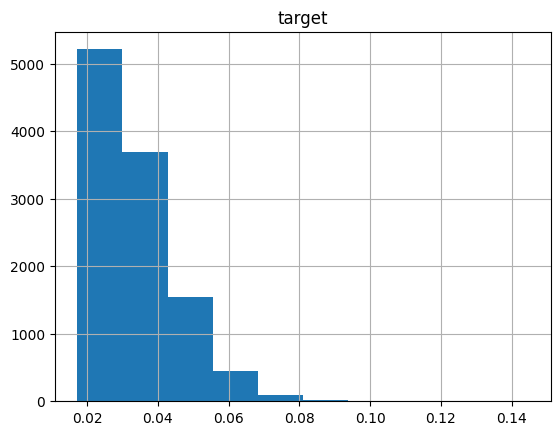

In [44]:
pd.DataFrame({"target": final_pred}).hist()
